# Escolhendo modelos

Dentre uma variedade gigante de modelos, vamos focar em 3: K-Nearest Neighbours (KNN), Suppport Vector Machines (SVM) e Long-short Term Memory Neural Networks (LSTM). As duas primeiras possuem diversas implementações no SkLearn, enquanto que a terceira pode ser usada com o PyTorch. 

Primeiro, vamos criar alguns dados dummy para podermos entender e visualizar o funcionamento dos algoritmos. Abaixo, temos um conjunto de dados com 500 amostras, duas dimensões (características) e três centros (classes).

Aumentando o desvio padrão (**cluster_std**) permite que os clusters fiquem mais esparsos, gerando intersecções entre elas. Vamos usar apenas duas características (**n_feats**) para podermos visualizar o problema.

In [1]:
import numpy as np
import pandas as pd
import gensim
from context import fakenews
from fakenews import preprocess as pre

In [2]:
from sklearn.datasets import make_blobs

dummyfeats, dummylbl = make_blobs(n_features=2, n_samples=2000, centers=3, cluster_std=3)

Os dados gerados serão diferentes a cada execução, mas **cluster_std=3** já é o suficiente para garantir alguma interseção entre as amostras. Acima disso já comça a virar bagunça!

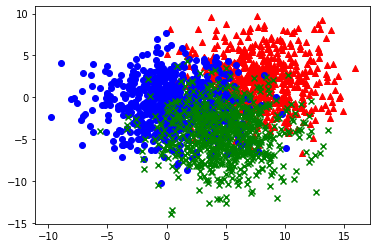

In [3]:
import matplotlib.pyplot as plt

def plot_data(data, lbls):
    c1 = data[lbls == 0]
    c2 = data[lbls == 1]
    c3 = data[lbls == 2]
    plt.scatter(c1[:, 0], c1[:, 1], marker='^', color='red')
    plt.scatter(c2[:, 0], c2[:, 1], marker='o', color='blue')
    plt.scatter(c3[:, 0], c3[:, 1], marker='x', color='green')
plot_data(dummyfeats, dummylbl)

Agora, precisamos dividir os dados em treino e teste. Poderíamos também adicionar um terceiro subconjunto **validação**, mas futuramente usaremos validação cruzada. Lembrando que, a **validação cruzada** permite simular o conjunto de validação quando não temos dados suficientes.

Vamos usar, novamente, o SkLearn para isso. O método abaixo possui várias customizações permitindo sua aplicação em diferentes cenários. Abaixo, a separação mais simples consiste em apenas escolher o tamanho do conjunto de teste (**test_size**)

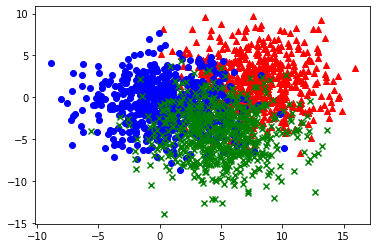

In [4]:
from sklearn.model_selection import train_test_split

dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.1)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

Em alguns casos, principalmente em problemas de identificação, pode ser necessário garantir que todas as classes estejam presentes em ambos os conjuntos. Podemos usar a separação estratificada (**stratify**), mantendo as proporções dos dados de acordo com alguma característica da base.

In [5]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

Por fim, para evitar que seus experimentos sejam tendenciados por ter escolhido um ponto muito no espaço de busca (ou muito ruim) também podemos embaralhar as amostras (**shuffle**). No entanto, acaba sendo desnecessário quando usamos validação cruzada.

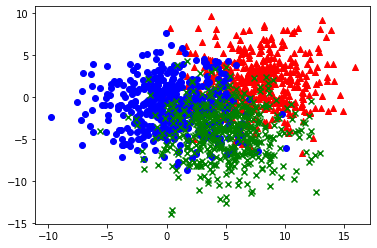

In [6]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl, shuffle=True)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

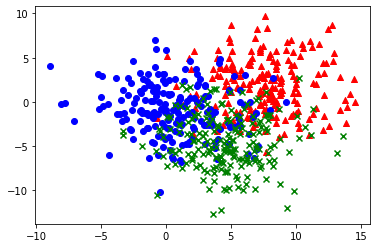

In [7]:
plot_data(dummy_ftest, dummylbl_test)

Com os dados devidamente separados, podemos aplicar ao nosso modelo para treinamento e teste. Vamos usar o KNN para exemplificar o procedimento, e mais na frente fazemos o mesmo de forma resumida para o SVM e o LSTM. Na maioria dos casos, os modelos do SkLearn fazem o treinamento a partir do método **fit**, o teste com o **predict**, os dois com o **fit_predict**, ou também podemos usar o **score** para calcular alguma métrica sobre a predição. 

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(dummy_ftrain, dummylbl_train)
knn.score(dummy_ftest, dummylbl_test)

0.7366666666666667

Com esses métodos, temos um modelo decente para classificar nossos dados. Mas ainda podemos ir além, pois o knn está usando apenas valores padrões. Embora sejam valores comuns, **não são os melhores!**. Vejamos quantos parâmetros o modelo posssui

In [9]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Temos um total de 8 parâmetros que podem ser ajustados no nosso modelo! Dentre eles, **p**, **n_neighbors** e **weights** podem afetar nossa performance. Vamos aumentar a quantidade de vizinhos e ver qual o efeito disso

In [10]:
knn.set_params(n_neighbors=7)
knn.score(dummy_ftest, dummylbl_test)

0.7516666666666667

E que tal reduzir pra 1?

In [11]:
knn.set_params(n_neighbors=1)
knn.score(dummy_ftest, dummylbl_test)

0.7

E pra 200?

In [12]:
knn.set_params(n_neighbors=200)
knn.score(dummy_ftest, dummylbl_test)

0.7666666666666667

Otimizar os parâmetros assim é bastante trabalhoso e aumenta substancialmente a probabilidade de errarmos ou esquecer alguma coisa no caminho. Para evitar isso, podemos automatizar nossa busca pelo modelo _"ótimo"_ para o nosso problema. Vamos usar uma forma mais simples e ordenada para otmização dos parâmetros: **Grid Search**.

Isso é literalmente criar uma malha (ou uma matriz, se preferir) onde podemos ver cada coluna como valores de parâmetros a serem otimizados, sendo assim as linhas as combinações entre esses parâmetros. Por exemplo, para o knn

In [13]:
from sklearn.model_selection import GridSearchCV

pgrid = [{'n_neighbors': [5, 10, 15, 20], 'p': [1, 2, 3]}]

estimator = KNeighborsClassifier()
gsearch = GridSearchCV(estimator, pgrid, cv=3)
gsearch.fit(dummy_ftrain, dummylbl_train)
cv_results = pd.DataFrame(gsearch.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001187,0.000270,0.026196,0.004029,5,1,"{'n_neighbors': 5, 'p': 1}",0.758030,0.721627,0.731760,0.737139,0.015340,12
1,0.000908,0.000100,0.020972,0.000379,5,2,"{'n_neighbors': 5, 'p': 2}",0.762313,0.738758,0.731760,0.744277,0.013069,11
2,0.001101,0.000206,0.025046,0.001257,5,3,"{'n_neighbors': 5, 'p': 3}",0.775161,0.743041,0.733906,0.750702,0.017692,10
3,0.001072,0.000318,0.023210,0.003079,10,1,"{'n_neighbors': 10, 'p': 1}",0.781585,0.747323,0.755365,0.761424,0.014629,8
4,0.000970,0.000081,0.024076,0.001421,10,2,"{'n_neighbors': 10, 'p': 2}",0.781585,0.753747,0.748927,0.761420,0.014394,9
5,0.001418,0.000077,0.034823,0.009623,10,3,"{'n_neighbors': 10, 'p': 3}",0.785867,0.755889,0.751073,0.764276,0.015393,7
6,0.000910,0.000045,0.022162,0.000627,15,1,"{'n_neighbors': 15, 'p': 1}",0.788009,0.758030,0.759657,0.768565,0.013765,3
7,0.000928,0.000087,0.021558,0.000654,15,2,"{'n_neighbors': 15, 'p': 2}",0.785867,0.758030,0.757511,0.767136,0.013247,4
8,0.001157,0.000279,0.027037,0.003200,15,3,"{'n_neighbors': 15, 'p': 3}",0.788009,0.760171,0.761803,0.769994,0.012756,1
9,0.001112,0.000170,0.023926,0.003231,20,1,"{'n_neighbors': 20, 'p': 1}",0.783726,0.755889,0.759657,0.766424,0.012331,5


O **pgrid** é justamente a matriz de combinações que queremos testar. Note que usamos o parâmetro **cv**, ele permite especificar qual tipo de validação cruzada queremos usar. No exemplo acima, optei por usar uma validação cruzada 3 estratificada.

Em seguida, visualizamos os resultados como um DataFrame. Mas o cv_results é um dicionário com várias informações sobre as execuções! Também podemos ver qual foi a melhor configuração, uma instância do melhor classficador,

In [14]:
print(f'Best conf: {gsearch.best_params_}')
gsearch.best_estimator_

Best conf: {'n_neighbors': 15, 'p': 3}


KNeighborsClassifier(n_neighbors=15, p=3)

Agora, com o nosso classificador bombado podemos usá-lo no conjunto de teste!

In [15]:
knn = gsearch.best_estimator_
knn.score(dummy_ftest, dummylbl_test)

0.765

Vamos visualizar os resultados de forma mais detalhada usando uma matriz de confusão

[[170  16  19]
 [ 10 139  31]
 [ 20  45 150]]


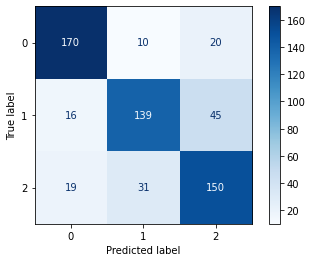

In [16]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

preds = knn.predict(dummy_ftest)
print(confusion_matrix(preds, dummylbl_test))
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Blues')

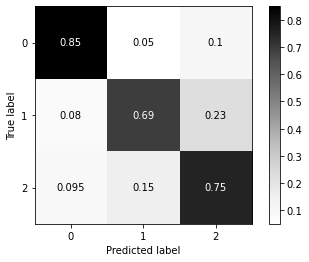

In [17]:
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Greys', normalize='true')

Então, temos um modelo ótimo? Provavelmente não, a forma como o GS funciona nos permite verificar onde provavelmente está o nosso valor ótimo e daí podemos realizar uma nova busca dentro desse intervalo. Entretanto isso é muito custoso e entramos num looping infinito! Por exemplo, podemos verificar a acarácia do modelo de acordo com variações em `k`

In [18]:
manh = cv_results[cv_results['param_p'] == 1]
eucl = cv_results[cv_results['param_p'] == 2]
mink = cv_results[cv_results['param_p'] == 3]
mink

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.001101,0.000206,0.025046,0.001257,5,3,"{'n_neighbors': 5, 'p': 3}",0.775161,0.743041,0.733906,0.750702,0.017692,10
5,0.001418,0.000077,0.034823,0.009623,10,3,"{'n_neighbors': 10, 'p': 3}",0.785867,0.755889,0.751073,0.764276,0.015393,7
8,0.001157,0.000279,0.027037,0.003200,15,3,"{'n_neighbors': 15, 'p': 3}",0.788009,0.760171,0.761803,0.769994,0.012756,1
11,0.000854,0.000040,0.024976,0.001369,20,3,"{'n_neighbors': 20, 'p': 3}",0.779443,0.751606,0.763948,0.764999,0.011389,6


(0.5, 1.0)

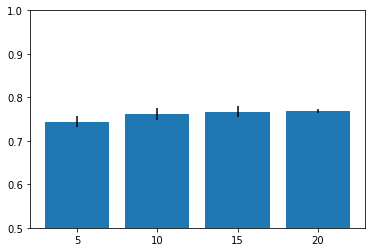

In [19]:
plt.bar(np.arange(4), eucl['mean_test_score'], tick_label=eucl['param_n_neighbors'], yerr=eucl['std_test_score'])
plt.ylim(.5, 1)

Como não há muita variação, isso indica que podemos aumentar o espaço de busca para o valor de `k`. Onde caso houve uma queda seguida de subida, indicaria o intervalo no qual uma nova busca pode ser realizada.

## Adicionano outros modelos para comparação

In [20]:
from sklearn.svm import SVC

svm = SVC()
pgrid = [{'kernel': ['rbf', 'sigmoid'], 'C':[0.01, 0.1, 1], 'gamma':[0.001, 0.01]},
         {'kernel': ['poly'], 'C':[0.01, 0.1, 1], 'gamma':[0.001, 0.01], 'degree':[2, 3]},]
gs_svm = GridSearchCV(svm, pgrid, cv=3)
gs_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(gs_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031298,0.003971,0.008624,0.000149,0.01,0.001,rbf,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",0.790150,0.331906,0.332618,0.484891,0.215851,18
1,0.040704,0.001583,0.013421,0.000489,0.01,0.001,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.788009,0.331906,0.332618,0.484177,0.214841,19
2,0.029467,0.000272,0.009078,0.000584,0.01,0.01,rbf,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.794433,0.749465,0.753219,0.765705,0.020371,6
3,0.057080,0.006422,0.022289,0.002509,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.783726,0.747323,0.759657,0.763569,0.015117,8
4,0.029426,0.002159,0.010856,0.001951,0.1,0.001,rbf,NaN,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.805139,0.747323,0.748927,0.767130,0.026885,5


In [21]:
bestsvm = gs_svm.best_estimator_
gs_svm.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [22]:
bestsvm.score(dummy_ftest, dummylbl_test)

0.7683333333333333

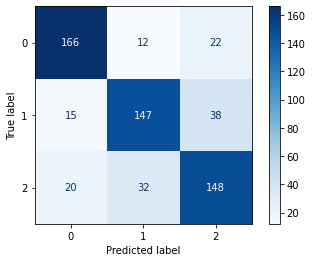

In [23]:
plot_confusion_matrix(bestsvm, dummy_ftest, dummylbl_test, cmap='Blues')

In [24]:
from sklearn.metrics import f1_score, make_scorer


scorer = make_scorer(f1_score, average='macro')
f1gs_svm = GridSearchCV(svm, pgrid, cv=3, scoring=scorer)
f1gs_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(f1gs_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032809,0.004162,0.011711,0.001127,0.01,0.001,rbf,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",0.786839,0.166131,0.166398,0.373123,0.292541,18
1,0.045277,0.001603,0.014178,0.000732,0.01,0.001,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.781764,0.166131,0.166398,0.371431,0.290149,19
2,0.025196,0.000438,0.009728,0.000594,0.01,0.01,rbf,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.793175,0.747837,0.753706,0.764906,0.020132,6
3,0.047113,0.000302,0.018105,0.000841,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.781817,0.744989,0.757593,0.761466,0.015282,9
4,0.021692,0.000470,0.009055,0.000157,0.1,0.001,rbf,NaN,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.803868,0.745546,0.749055,0.766156,0.026705,5


In [25]:
bestf1_svm = f1gs_svm.best_estimator_
f1gs_svm.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [26]:
preds = bestf1_svm.predict(dummy_ftest)
f1_score(preds, dummylbl_test, average='macro')

0.7684461764032657

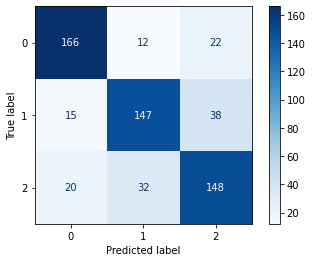

In [27]:
plot_confusion_matrix(bestf1_svm, dummy_ftest, dummylbl_test, cmap='Blues')

In [28]:
rbfresults = results[results['param_kernel'] == 'sigmoid']
rbfresults_gamma = rbfresults[rbfresults['param_gamma'] == 0.01]
rbfresults_gamma

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.047113,0.000302,0.018105,0.000841,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.781817,0.744989,0.757593,0.761466,0.015282,9
7,0.030957,0.001921,0.013566,0.000618,0.1,0.01,sigmoid,NaN,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.795116,0.754527,0.751464,0.767036,0.019895,3
11,0.022846,0.001915,0.009938,0.000487,1,0.01,sigmoid,NaN,"{'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.746586,0.741421,0.731923,0.739977,0.006072,10


(0.5, 1.0)

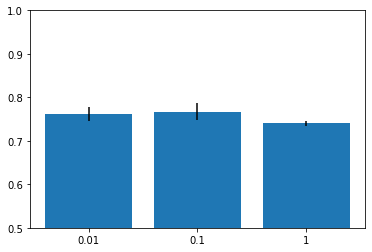

In [29]:
plt.bar(np.arange(3), 
        rbfresults_gamma['mean_test_score'],
        tick_label=rbfresults_gamma['param_C'],
        yerr=rbfresults_gamma['std_test_score'])

plt.ylim(.5, 1)

Nesse caso podemos visualizar que ao aumentar `C` de 0.1 para 1, com $\gamma = 0.01$, a acurácia reduz consecutivamente. Isso indica que o ótimo deve estar entre os valores 0.01 e 0.1. Dessa forma, caso queiramos otimizar ainda mais o modelo, poderíamos expandir o intervalo de $C$ para $C\in[0.01, 0.03, 0.05, 0.07, 0.09, 0.1]$ e repetir o processo quantas vezes for necessário.

### Randomized Search

Também podemos usar outras técnicas de otimização como a busca **aleatória** e em **árvore**. Ao contrário  do GS, a busca aleatória usa distribuições ao invés de valores fixos. O SkLearn não disponibiliza uma classe para busca em árvore, mas tendo em vista que isso é nada mais que um backpropagation com prunning, podemos usar de outras bibliotecas.

Para gerar as distribuições, o módulo ´stats´ do scipy oferece: exponencial, uniforme, gamma e outras.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

rnd_space = [{'kernel': ['rbf'], 'C':expon(scale=10), 'gamma':expon(scale=.1)}]
rnds_svm = RandomizedSearchCV(SVC(), rnd_space, cv=3)
rnds_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(rnds_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022319,0.004107,0.004622,0.000108,8.27152,0.0305695,rbf,"{'C': 8.271516988372586, 'gamma': 0.0305694883...",0.802998,0.758030,0.761803,0.774277,0.020367,4
1,0.040033,0.002460,0.004855,0.000125,34.3559,0.0599194,rbf,"{'C': 34.355851490577216, 'gamma': 0.059919397...",0.796574,0.755889,0.757511,0.769991,0.018809,7
2,0.036690,0.005154,0.006402,0.001346,6.63403,0.166602,rbf,"{'C': 6.634033779751054, 'gamma': 0.1666021636...",0.792291,0.760171,0.746781,0.766415,0.019097,10
3,0.016038,0.001161,0.004548,0.000054,4.28975,0.0191452,rbf,"{'C': 4.289750029606486, 'gamma': 0.0191452037...",0.796574,0.760171,0.768240,0.774995,0.015610,2
4,0.013585,0.000773,0.004868,0.000349,9.49531,0.00258371,rbf,"{'C': 9.495307563284863, 'gamma': 0.0025837132...",0.794433,0.758030,0.766094,0.772852,0.015611,5


In [31]:
bestrnd_svm = rnds_svm.best_estimator_
rnds_svm.best_params_

{'C': 12.380957117465464, 'gamma': 0.01960278766000524, 'kernel': 'rbf'}

In [32]:
bestrnd_svm.score(dummy_ftest, dummylbl_test)

0.7683333333333333

Note que agora os parâmetros estão numa escala bem diferente comparadas ao GridSearch! Outra parte importante sobre o randomized é a quantidade de amostras, por padrão são usadas 10 amostras das distribuições, mas podemos alterar isso usando com o `n_iter=30`

In [33]:
rnd_space = [{'kernel': ['rbf'], 'C':expon(scale=10), 'gamma':expon(scale=.1)}]
rnds_svm = RandomizedSearchCV(SVC(), rnd_space, cv=3, n_iter=30)
rnds_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(rnds_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025376,0.005886,0.005773,0.001357,5.45125,0.0338119,rbf,"{'C': 5.451245762686504, 'gamma': 0.0338118658...",0.802998,0.755889,0.759657,0.772848,0.021375,13
1,0.022322,0.002708,0.005321,0.000568,0.521691,0.108485,rbf,"{'C': 0.5216912732881441, 'gamma': 0.108484748...",0.796574,0.755889,0.761803,0.771422,0.017948,16
2,0.017273,0.001359,0.007541,0.000956,1.01673,0.0370157,rbf,"{'C': 1.0167330431840258, 'gamma': 0.037015712...",0.798715,0.753747,0.761803,0.771422,0.019578,16
3,0.023864,0.005913,0.004887,0.000581,3.61877,0.0527174,rbf,"{'C': 3.618768165341086, 'gamma': 0.0527174300...",0.800857,0.755889,0.759657,0.772134,0.020368,15
4,0.018420,0.002977,0.004998,0.000254,10.6128,0.0132708,rbf,"{'C': 10.612770198585974, 'gamma': 0.013270791...",0.800857,0.762313,0.763948,0.775706,0.017797,4


In [34]:
bestrnd_svm = rnds_svm.best_estimator_
rnds_svm.best_params_

{'C': 12.98391050113722, 'gamma': 0.009241665681342801, 'kernel': 'rbf'}

In [35]:
bestrnd_svm.score(dummy_ftest, dummylbl_test)

0.7683333333333333

### Aplicando as fakenews

Vamos carregar os dados e aplicar os passos do preprocessamento novamente (sim, eu esqueci de salvar a base). Mas ainda precisamos fazer mais alguns passos antes de aplicar aos modelos.

In [37]:
base = '/home/thales/dev/fakenews/'
news, labels = pre.run(base + 'data/Fake.csv', base + 'data/True.csv')
print(news[0][:10])

Succesfully read data from:
Fakes: /home/thales/dev/fakenews/data/Fake.csv
Reals: /home/thales/dev/fakenews/data/True.csv
Removing rows without text...
Removing publisher information...
Adding class column...
Merging fakes and reals
Merging titles and bodies...
Removing subjects and date...
Tokenizing data...
['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald']


In [38]:
pre.truncate_news(news)

Truncating at 869


Vamos novamente, mais uma vez, carregar nosso modelo w2v na memória. Entretanto, o que o w2v modela?

In [39]:
w2v = gensim.models.Word2Vec.load('fakenews-w2v.model')

In [40]:
news[0][:10]

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing',
 'donald']

O w2v está modelando cada palavra, entretanto estamos tentando identificar se o DOCUMENTO (new) é fake ou não. Então, precisamos ajustar as features, ou a forma de predição dos classificadores. No caso das features

In [41]:
splits = train_test_split(news, labels, test_size=0.3, shuffle=True)
news_trn, news_tst, labels_trn, labels_tst = splits

trn_vecs = []
for new in news_trn:
    vecs = w2v.wv[new]
    meanvec = np.mean(vecs, axis=0)
    trn_vecs.append(meanvec)

trn_vecs = np.array(trn_vecs)
    
tst_vecs = []
for new in news_tst:
    vecs = w2v.wv[new]
    meanvec = np.mean(vecs, axis=0)
    tst_vecs.append(meanvec)

tst_vecs = np.array(tst_vecs)

In [42]:
print(f'Training data shape: {trn_vecs.shape}')
print(f'Test data shape: {tst_vecs.shape}')

Training data shape: (30986, 100)
Test data shape: (13281, 100)


In [43]:
models = [KNeighborsClassifier()]
pgrids = [
    {'n_neighbors': [4, 8, 16], 'p': [2, 3]}
]

In [44]:
best_models = []
for model, grid in zip(models, pgrids):
    optimizer = GridSearchCV(model, grid, cv=3)
    optimizer.fit(trn_vecs, labels_trn)
    best_models.append(optimizer.best_estimator_)

best_models

[KNeighborsClassifier(n_neighbors=16)]

In [45]:
for model in best_models:
    testacc = model.score(tst_vecs, labels_tst)
    print(testacc)

0.9367517506211882


Quanto a alterar a forma de predição, precisamos expandir os rótulos. Essa expansão adiciona um label para cada palavra onde esse label corresponde ao label do notícia. Desa forma, para o knn, vamos predizer para cada palvra e usar a classe mais frequente como resultado final. Para o SVM, podemos fazer algo semelhante.